# Analysis of NASDAQ
## *Giovanni Piva* 

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import mplfinance as mpf
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
from datetime import date, timedelta
import warnings

### INDEX

- [DATA](##1.-Data)
- [CLEANING](##2.-Cleaning-and-Preprocessing)
- [FEATURE ENGINEERING](##3.-feature-engineering-and-analysis)
- [STRATEGY](##4.-strategy)
- [HIDDEN MARKOV MODEL](##5.-hidden-markov-model)
- [BACKTEST](##6.-backtest)

## 1. Data

data: https://drive.google.com/file/d/1IthEOPcW6dKeKbr6cH6LKtZxNw1D9fTc/view?usp=sharing

In [2]:
df = pd.read_csv('./NQ_from_2000.txt', sep=',')
df

,Date,Time,Open,High,Low,Close,Up,Down,PLOT1,PLOT2
0,01/03/2000,01:00,6975.50,6977.00,6975.50,6975.50,3,0,0.0,0.0
1,01/03/2000,02:00,6977.50,6979.50,6977.50,6979.50,2,0,-1.0,-1.0
2,01/03/2000,03:00,6979.50,6993.50,6979.50,6987.50,21,0,-1.0,-1.0
3,01/03/2000,04:00,6986.50,6994.50,6984.50,6992.50,16,0,-1.0,-1.0
4,01/03/2000,05:00,6994.50,6999.50,6993.50,6999.50,19,0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...
148538,10/06/2025,09:00,25191.75,25221.75,25116.75,25155.50,33012,34236,25099.0,24995.0
148539,10/06/2025,10:00,25156.00,25185.00,25108.50,25152.25,32934,32929,25099.0,24995.0
148540,10/06/2025,11:00,25152.00,25216.00,25143.00,25208.00,22073,21360,25099.0,24995.0
148541,10/06/2025,12:00,25207.75,25211.50,25182.75,25202.25,13421,14362,25099.0,24995.0


In [3]:
df.shape

(148543, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148543 entries, 0 to 148542
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Date    148543 non-null  object 
 1   Time    148543 non-null  object 
 2   Open    148543 non-null  float64
 3   High    148543 non-null  float64
 4   Low     148543 non-null  float64
 5   Close   148543 non-null  float64
 6   Up      148543 non-null  int64  
 7   Down    148543 non-null  int64  
 8   PLOT1   148543 non-null  float64
 9   PLOT2   148543 non-null  float64
dtypes: float64(6), int64(2), object(2)
memory usage: 11.3+ MB


**No missing Values**

In [5]:
# Statistics

df_stats = df.drop(columns=['Date', 'Time'])
stats = df_stats.describe().T[['mean', 'std', 'min', 'max']]
stats['range'] = stats['max'] - stats['min']
stats['var'] = df_stats.var()
stats['cv'] = stats['std'] / stats['mean']  
stats['skew'] = df_stats.skew()
stats['kurt'] = df_stats.kurt()
stats[['mean', 'std', 'cv', 'min', 'max', 'range', 'var', 'skew', 'kurt']]

stats

,mean,std,min,max,range,var,cv,skew,kurt
Open,8437.213142,5309.106622,3679.00,25207.75,21528.75,2.818661e+07,0.629249,1.291544,0.480612
High,8447.073766,5317.811765,3695.50,25241.50,21546.00,2.827912e+07,0.629545,1.290963,0.477738
Low,8426.858608,5299.781251,3672.50,25183.00,21510.50,2.808768e+07,0.628915,1.292122,0.483584
Close,8437.340378,5309.280346,3678.75,25211.50,21532.75,2.818846e+07,0.629260,1.291546,0.480668
Up,7467.873558,11654.206631,0.00,124803.00,124803.00,1.358205e+08,1.560579,2.283580,6.099466
Down,7434.885562,11762.640834,0.00,123351.00,123351.00,1.383597e+08,1.582088,2.304231,6.231977
PLOT1,8479.677989,5346.527075,-1.00,25196.50,25197.50,2.858535e+07,0.630511,1.288067,0.464323
PLOT2,8381.488103,5258.648791,-1.00,24995.00,24996.00,2.765339e+07,0.627412,1.293107,0.491159


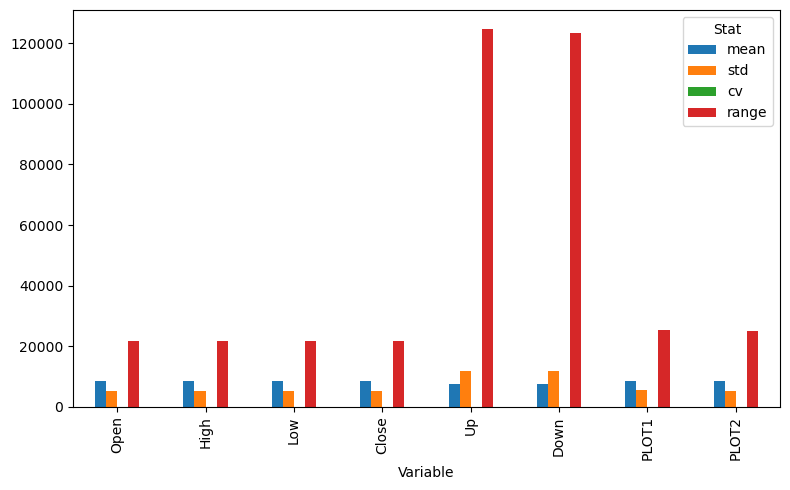

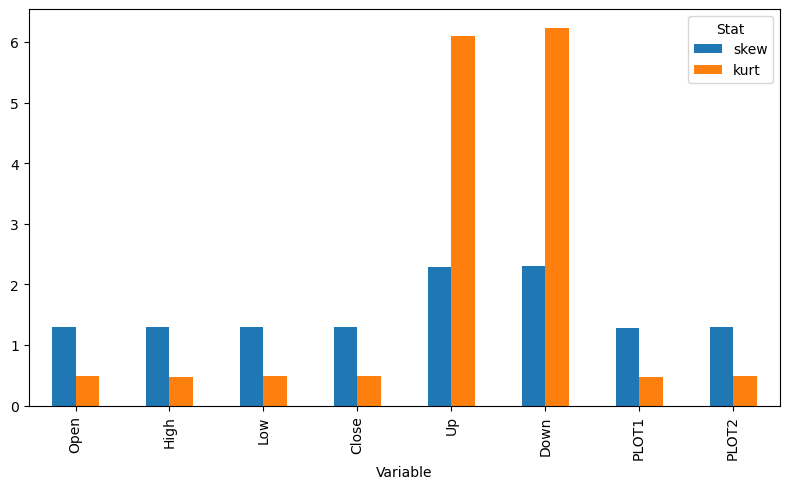

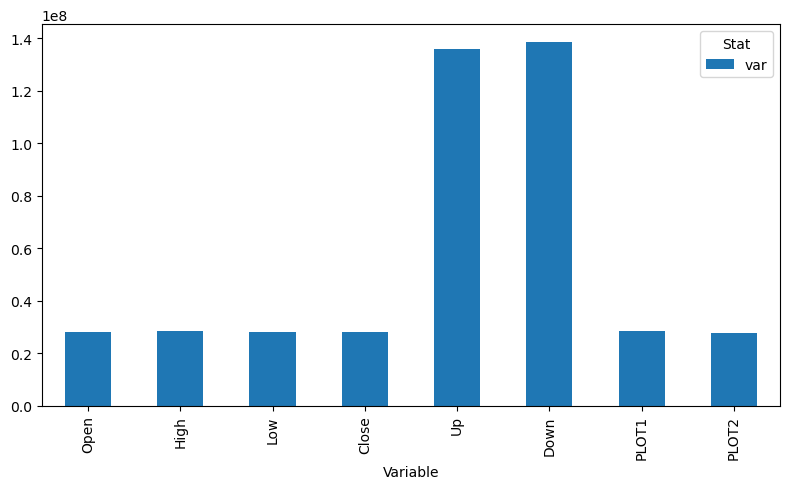

In [6]:
stats[['mean', 'std', 'cv', 'range']].plot(kind='bar', figsize=(8, 5))
plt.xlabel('Variable')
plt.legend(title='Stat')
plt.tight_layout()
plt.show()

stats[['skew', 'kurt']].plot(kind='bar', figsize=(8, 5))
plt.xlabel('Variable')
plt.legend(title='Stat')
plt.tight_layout()
plt.show()

stats[['var']].plot(kind='bar', figsize=(8, 5))
plt.xlabel('Variable')
plt.legend(title='Stat')
plt.tight_layout()
plt.show()

In [7]:
df.tail(10)

,Date,Time,Open,High,Low,Close,Up,Down,PLOT1,PLOT2
148533,10/06/2025,04:00,25081.25,25114.75,25078.25,25106.75,2756,2415,25099.0,24995.0
148534,10/06/2025,05:00,25106.50,25139.50,25104.25,25134.50,2155,1762,25099.0,24995.0
148535,10/06/2025,06:00,25134.50,25185.00,25124.25,25171.25,4404,3915,25099.0,24995.0
148536,10/06/2025,07:00,25171.00,25186.00,25128.50,25184.25,5429,4933,25099.0,24995.0
148537,10/06/2025,08:00,25185.00,25241.50,25179.00,25191.25,7584,7027,25099.0,24995.0
148538,10/06/2025,09:00,25191.75,25221.75,25116.75,25155.50,33012,34236,25099.0,24995.0
148539,10/06/2025,10:00,25156.00,25185.00,25108.50,25152.25,32934,32929,25099.0,24995.0
148540,10/06/2025,11:00,25152.00,25216.00,25143.00,25208.00,22073,21360,25099.0,24995.0
148541,10/06/2025,12:00,25207.75,25211.50,25182.75,25202.25,13421,14362,25099.0,24995.0
148542,10/06/2025,13:00,25202.50,25231.75,25183.00,25211.50,13245,12988,25099.0,24995.0


In [8]:
# Detect anomalies

def check(df):

    # Duplicates
    duplicates = df.index.duplicated().sum()
    print(f"Duplicated timestamps: {duplicates}")
    if duplicates > 0:
        print(df[df.index.duplicated(keep=False)].head())

    # Negative prices
    price_cols = ['Open', 'High', 'Low', 'Close']
    negatives = (df[price_cols] < 0).sum()
    print("\nNegative values per column:")
    print(negatives)

    # Price Errors (High < Low)
    wrong_range = (df['High'] < df['Low']).sum()
    print(f"\nRows with High < Low: {wrong_range}")

    # Close/Open outside range 
    bad_close = ((df['Close'] < df['Low']) | (df['Close'] > df['High'])).sum()
    print(f"Close outside [Low, High] range: {bad_close}")
    bad_open = ((df['Open'] < df['Low']) | (df['Open'] > df['High'])).sum()
    print(f"Open outside [Low, High] range: {bad_open}")

    # Outlier detection (Z-score > 5)
    returns = df['Close'].pct_change()
    z = np.abs((returns - returns.mean()) / returns.std())
    outliers = (z > 5).sum()
    print(f"\nExtreme outliers (|Z| > 5): {outliers}")

check(df)

Duplicated timestamps: 0

Negative values per column:
Open     0
High     0
Low      0
Close    0
dtype: int64

Rows with High < Low: 0
Close outside [Low, High] range: 0
Open outside [Low, High] range: 0

Extreme outliers (|Z| > 5): 800


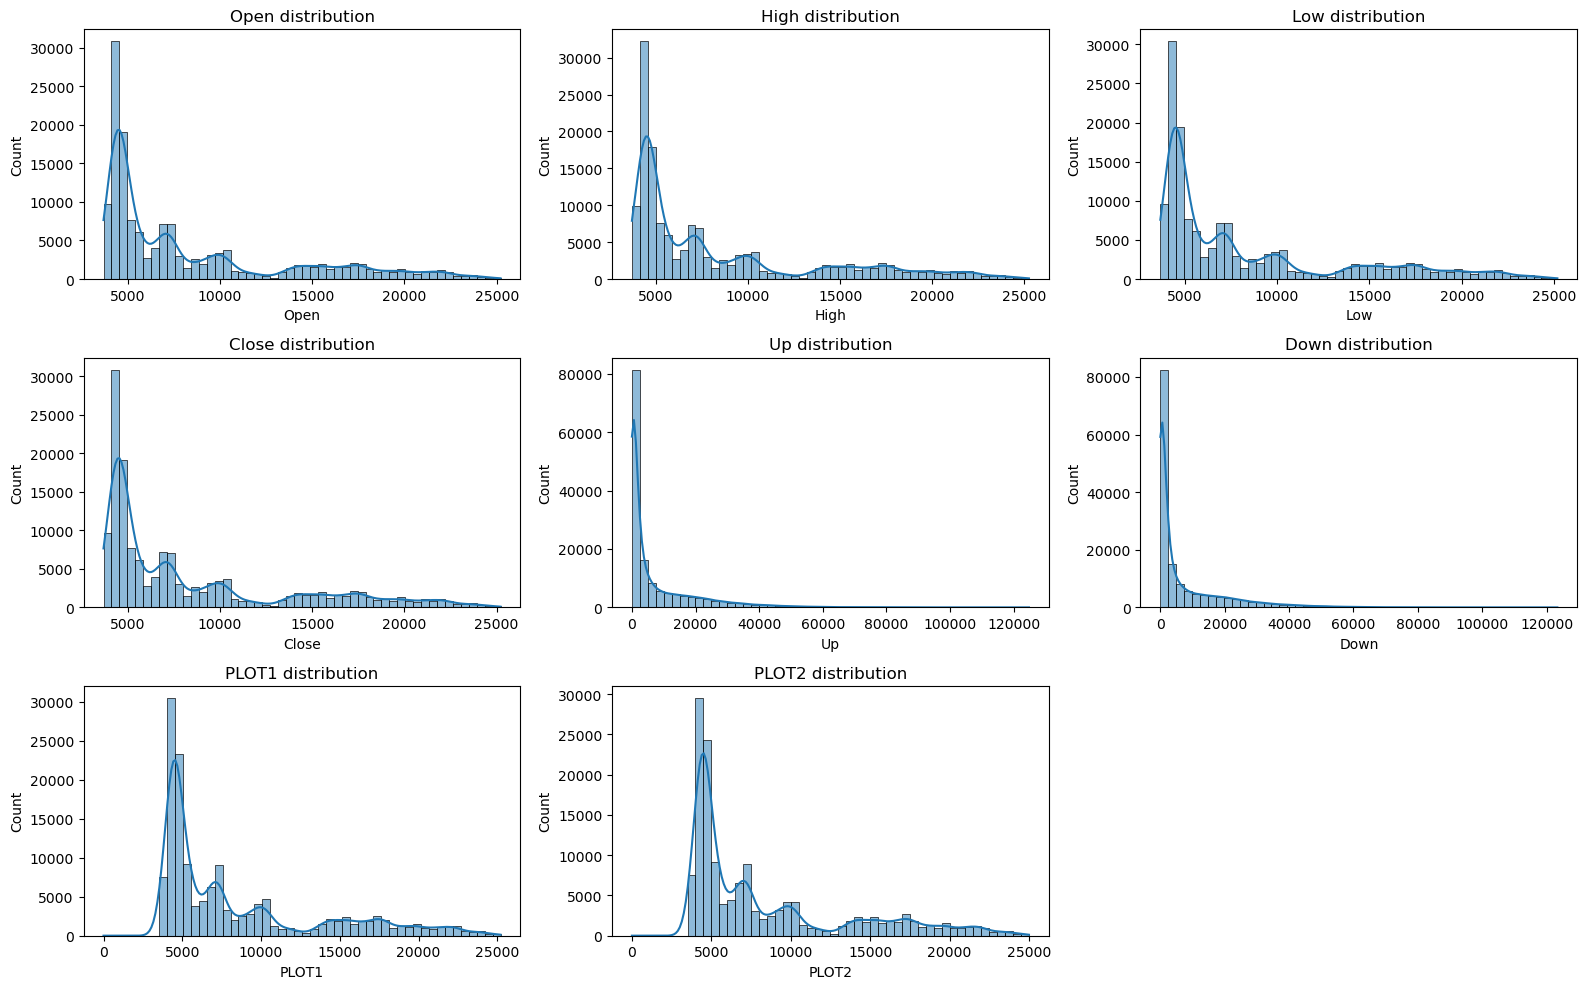

In [ ]:
# Features ditributions

warnings.filterwarnings("ignore")


features = ['Open', 'High', 'Low', 'Close', 'Up', 'Down', 'PLOT1', 'PLOT2']

plt.figure(figsize=(16, 10))
for i, col in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col].dropna(), kde=True, bins=50)
    plt.title(f'{col} distribution')
plt.tight_layout()
plt.show()

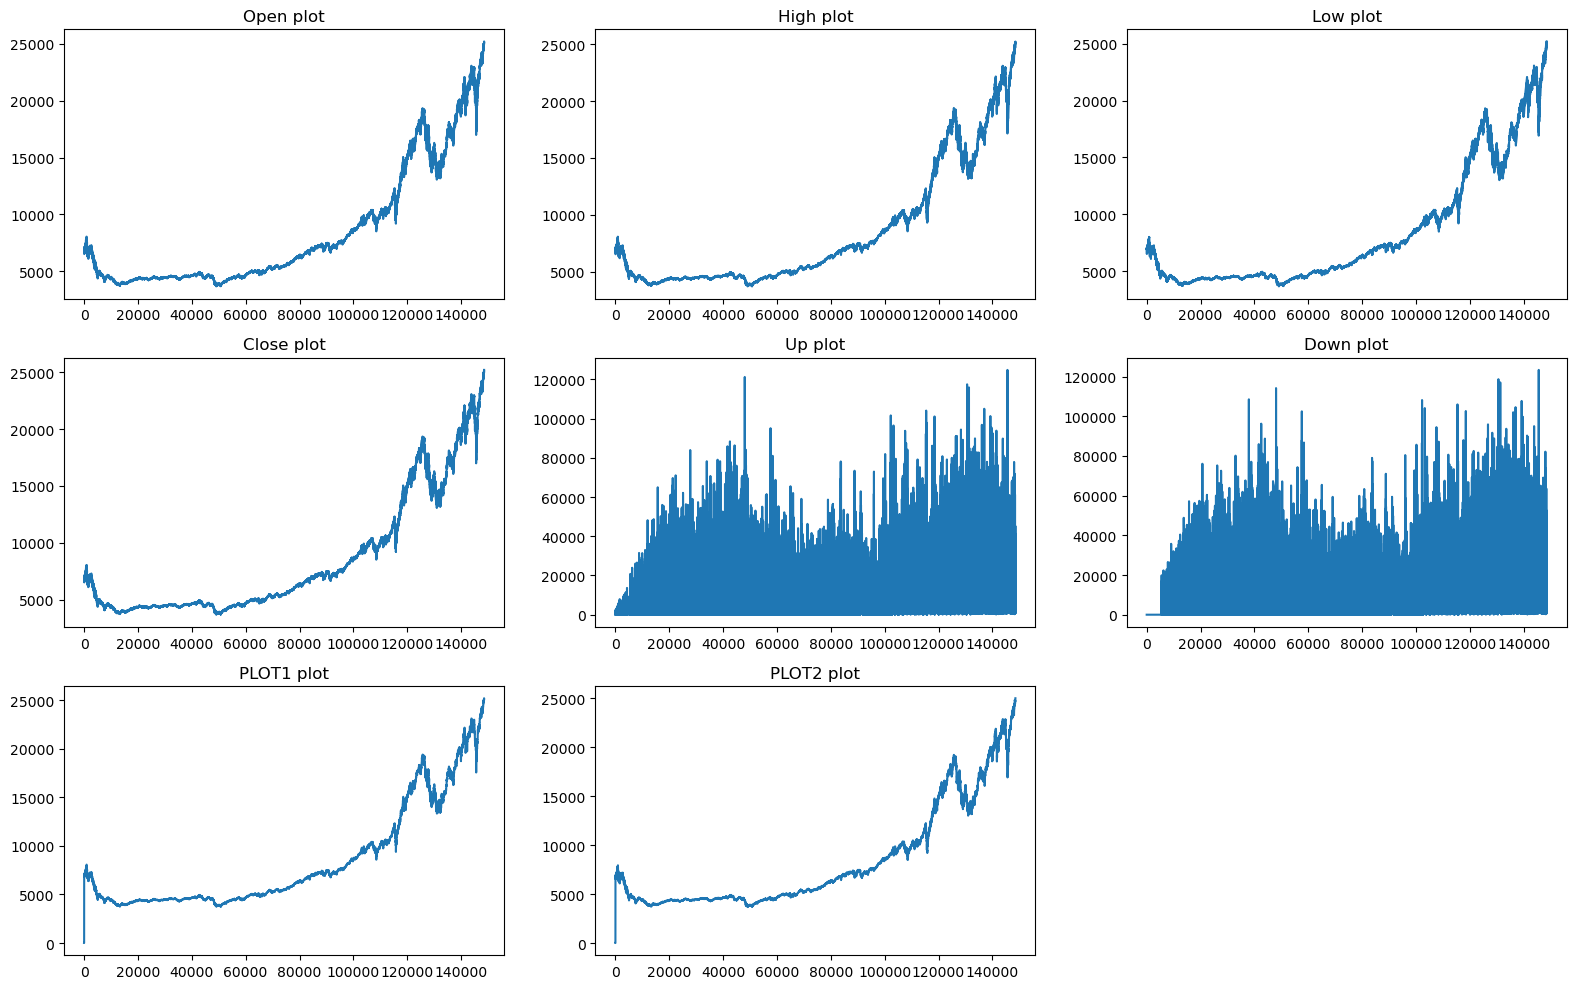

In [10]:
# Features plots

warnings.filterwarnings("ignore")

plt.figure(figsize=(16, 10))
for i, col in enumerate(features, 1):
    plt.subplot(3, 3, i)
    plt.plot(df[col].dropna())
    plt.title(f'{col} plot')
plt.tight_layout()
plt.show()

## 2. Cleaning and Preprocessing

### DATES

In [11]:
# Merge Date and Time

df['datetime'] = df['Date'] + ' ' + df['Time']
df['datetime'] = pd.to_datetime(df['datetime'], format='%m/%d/%Y %H:%M')
df = df.set_index('datetime')
df = df.drop(columns=['Date', 'Time'])

df.head(1)

,Open,High,Low,Close,Up,Down,PLOT1,PLOT2
datetime,,,,,,,,
2000-01-03 01:00:00,6975.5,6977.0,6975.5,6975.5,3,0,0.0,0.0


In [12]:
# Missing days 

def find_missing_business_days(df, calendar=None):

    start = df.index.min().normalize()
    end   = df.index.max().normalize()

    all_bd = pd.bdate_range(start, end)

    if calendar is not None:
        all_bd = all_bd.difference(calendar)

    present_days = df.index.normalize().unique()
    missing = all_bd.difference(present_days)

    return missing

miss = find_missing_business_days(df)
print("Missing days:", miss) 
print("Total:", miss.shape[0])


Missing days: DatetimeIndex(['2000-01-17', '2000-02-21', '2000-04-21', '2000-05-29',
               '2000-07-04', '2000-09-04', '2000-11-23', '2000-12-25',
               '2001-01-01', '2001-01-15', '2001-02-19', '2001-03-01',
               '2001-04-13', '2001-09-12', '2001-09-13', '2001-09-14',
               '2001-12-25', '2002-01-01', '2002-03-29', '2002-12-25',
               '2003-01-01', '2003-04-18', '2003-07-04', '2003-12-25',
               '2004-01-01', '2004-04-09', '2004-12-24', '2005-03-25',
               '2006-04-14', '2006-12-25', '2007-01-01', '2007-12-25',
               '2008-01-01', '2008-03-21', '2008-12-25', '2009-01-01',
               '2009-04-10', '2009-12-25', '2010-01-01', '2010-12-24',
               '2011-04-22', '2011-12-26', '2012-01-02', '2012-12-25',
               '2013-01-01', '2013-03-29', '2013-12-25', '2014-01-01',
               '2014-04-18', '2015-12-25', '2016-01-01', '2016-03-25',
               '2017-04-14', '2018-03-30', '2019-04-19', '2020-

**The missing days correspond to official U.S. market holidays or special trading halts (like Good Friday, Independence Day, Christmas, or the post-9/11 closure). Since the Nasdaq futures market was closed on those days and no trading data is available, the absence of observations is expected and not indicative of data loss.**

In [13]:
# Verifying Dates are correctly sorted

is_sorted = df.index.is_monotonic_increasing
print(is_sorted)

True


## 3. Feature Engineering and Analysis

In [14]:
df['return'] = df['Close'].pct_change()
df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))

window = 96 # !!!
rs = df['log_return'].rolling(window).std().shift(1) # shift 1 --> NO LOOK-AHEAD BIAS!!
rm = df['log_return'].rolling(window).mean().shift(1)
z = (df['log_return'] - rm) / rs
df['rolling_vol'] = rs
df['rolling_mean'] = rm
df['z-score'] = z

#df['range_ratio'] = (df['High'] - df['Low']) / df['Open']
#df['net_tick_bias'] = df['Up'] - df['Down']

# useless cols
df.drop(columns=(['Up', 'Down', 'PLOT1', 'PLOT2']), inplace=True)

df

,Open,High,Low,Close,return,log_return,rolling_vol,rolling_mean,z-score
datetime,,,,,,,,,
2000-01-03 01:00:00,6975.50,6977.00,6975.50,6975.50,NaN,NaN,NaN,NaN,NaN
2000-01-03 02:00:00,6977.50,6979.50,6977.50,6979.50,0.000573,0.000573,NaN,NaN,NaN
2000-01-03 03:00:00,6979.50,6993.50,6979.50,6987.50,0.001146,0.001146,NaN,NaN,NaN
2000-01-03 04:00:00,6986.50,6994.50,6984.50,6992.50,0.000716,0.000715,NaN,NaN,NaN
2000-01-03 05:00:00,6994.50,6999.50,6993.50,6999.50,0.001001,0.001001,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2025-10-06 09:00:00,25191.75,25221.75,25116.75,25155.50,-0.001419,-0.001420,0.001408,0.000163,-1.124289
2025-10-06 10:00:00,25156.00,25185.00,25108.50,25152.25,-0.000129,-0.000129,0.001416,0.000150,-0.197444
2025-10-06 11:00:00,25152.00,25216.00,25143.00,25208.00,0.002217,0.002214,0.001416,0.000143,1.462240


In [15]:
# Correlation

corr = df.corr(numeric_only=True, method="pearson") 
corr.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

,Open,High,Low,Close,return,log_return,rolling_vol,rolling_mean,z-score
Open,1.000000,0.999995,0.999993,0.999991,0.003527,0.003106,0.360164,0.068537,-0.005831
High,0.999995,1.000000,0.999988,0.999994,0.005341,0.004910,0.361206,0.067951,-0.004503
Low,0.999993,0.999988,1.000000,0.999994,0.005586,0.005175,0.359105,0.069077,-0.004268
Close,0.999991,0.999994,0.999994,1.000000,0.007287,0.006866,0.360177,0.068490,-0.003047
return,0.003527,0.005341,0.005586,0.007287,1.000000,0.999978,0.004005,-0.012315,0.807844
log_return,0.003106,0.004910,0.005175,0.006866,0.999978,1.000000,0.002365,-0.011553,0.808090
rolling_vol,0.360164,0.361206,0.359105,0.360177,0.004005,0.002365,1.000000,-0.188025,0.014775
rolling_mean,0.068537,0.067951,0.069077,0.068490,-0.012315,-0.011553,-0.188025,1.000000,-0.084082
z-score,-0.005831,-0.004503,-0.004268,-0.003047,0.807844,0.808090,0.014775,-0.084082,1.000000


### ROLLOVER CHECK

**As we are dealing with futures, we need to check if prices are already adjusted.**

In [ ]:
# expiry and roll dates

start_year = 2000
end_year = 2025
quarter_months = [3, 6, 9, 12]

def expiry_dates(year: int, month: int) -> date:
    d = date(year, month, 1)
    days_to_first_friday = (4 - d.weekday()) % 7
    first_friday = d + timedelta(days=days_to_first_friday)
    third_friday = first_friday + timedelta(weeks=2)
    return third_friday

def roll_dates(year: int, month: int) -> date:
    d = date(year, month, 1)
    days_to_first_thursday = (3 - d.weekday()) % 7  
    first_thursday = d + timedelta(days=days_to_first_thursday)
    second_thursday = first_thursday + timedelta(weeks=1)
    return second_thursday

expiries = [                    # third Fridays of Mar, Jun, Sept, Dec
    expiry_dates(year, month)
    for year in range(start_year, end_year + 1)
    for month in quarter_months
]

roll_d = [                      # second Thursdays
    roll_dates(year, month)
    for year in range(start_year, end_year + 1)
    for month in quarter_months
]

<Figure size 1200x600 with 0 Axes>

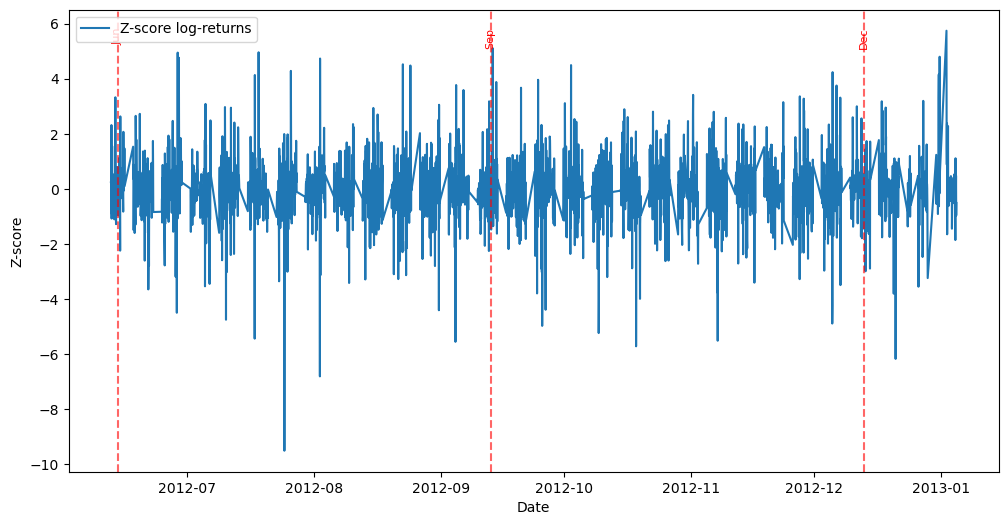

In [17]:
# check 

df_roll = df.iloc[70000:73300]
plt.figure(figsize=(12, 6))

plt.figure(figsize=(12, 6))
plt.plot(df_roll['z-score'], label='Z-score log-returns')

# Conversione sicura
roll_dates_ts = [pd.Timestamp(d) for d in roll_d]

# Aggiungi linee rosse solo per i roll dentro l'intervallo visibile
for d in roll_dates_ts:
    if df_roll.index.min() <= d <= df_roll.index.max():
        plt.axvline(d, color='red', linestyle='--', alpha=0.6)
        plt.text(d, plt.ylim()[1]*0.9, d.strftime('%b'),
                 rotation=90, color='red', ha='center', va='top', fontsize=8)

plt.xlabel('Date')
plt.ylabel('Z-score')
plt.legend()
plt.show()

**Seems ok, otherwise we'd see structural breaks along the red lines. This high-variance oscillatory pattern is typical of futures spreads, where the spread fluctuates sharply around its mean and frequently reverts, causing large z-score excursions in both directions.**

**Let's also check if the returns follow a normal distribution.**

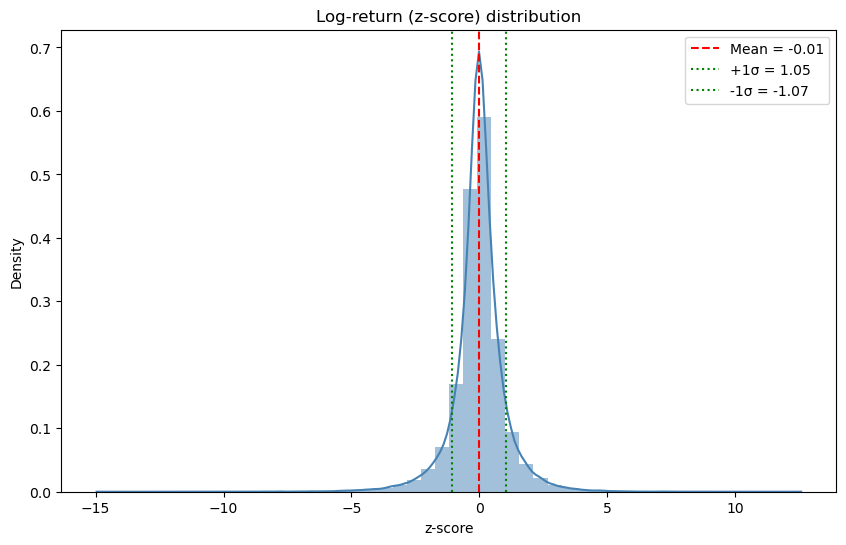

In [18]:
# z-score distribution

def distribution(logret, bins=50):
    logret = logret[~np.isnan(logret)]  
    
    plt.figure(figsize=(10,6))
    
    sns.histplot(logret, bins=bins, kde=True, stat="density", color="steelblue", edgecolor=None)
    
    mu = np.mean(logret)
    sigma = np.std(logret)
    plt.axvline(mu, color="red", linestyle="--", label=f"Mean = {mu:.2f}")
    plt.axvline(mu+sigma, color="green", linestyle=":", label=f"+1σ = {mu+sigma:.2f}")
    plt.axvline(mu-sigma, color="green", linestyle=":", label=f"-1σ = {mu-sigma:.2f}")
    
    plt.title("Log-return (z-score) distribution")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

logret = df['z-score']
distribution(logret)

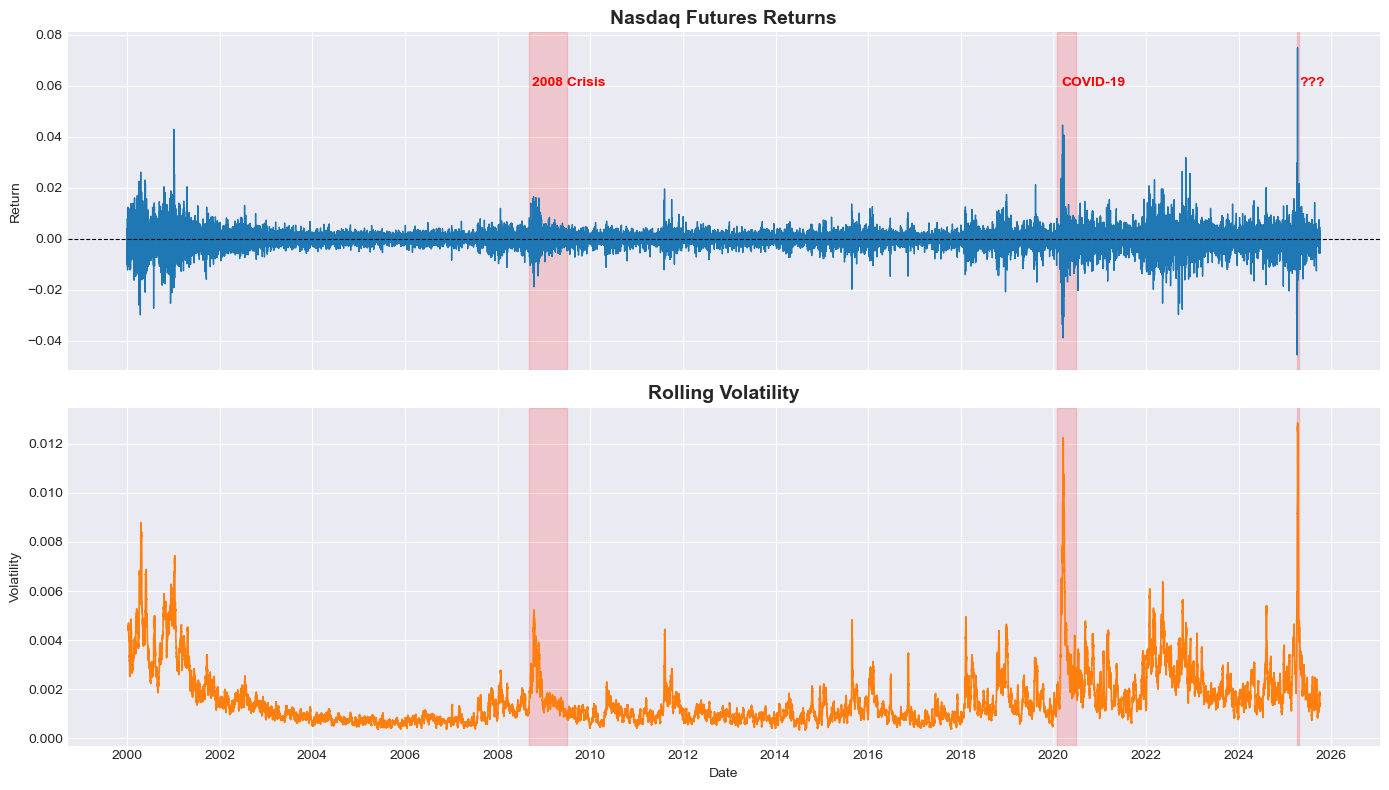

In [19]:
import matplotlib.dates as mdates

def highlight_periods(ax, periods, color='gray', alpha=0.2):
    for start, end in periods:
        ax.axvspan(start, end, color=color, alpha=alpha)

def plot(df):
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # 1) Returns
    axes[0].plot(df.index, df['return'], color='tab:blue', linewidth=1)
    axes[0].set_title('Nasdaq Futures Returns', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Return')
    axes[0].axhline(0, color='black', linewidth=0.8, linestyle='--')

    # 2) Volatility
    axes[1].plot(df.index, df['rolling_vol'], color='tab:orange', linewidth=1.2)
    axes[1].set_title('Rolling Volatility', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Volatility')
    axes[1].set_xlabel('Date')

    # 2008, COVID 
    crisis_periods = [
        ('2008-09-01', '2009-06-30'),
        ('2020-02-01', '2020-07-01'),
        ('2025-04-09', '2025-04-25')
    ]
    highlight_periods(axes[0], crisis_periods, color='red', alpha=0.15)
    highlight_periods(axes[1], crisis_periods, color='red', alpha=0.15)

    # Annotazioni
    axes[0].text(pd.Timestamp('2008-10-01'), df['return'].max() * 0.8,
                 '2008 Crisis', color='red', fontsize=10, weight='bold')
    axes[0].text(pd.Timestamp('2020-03-01'), df['return'].max() * 0.8,
                 'COVID-19', color='red', fontsize=10, weight='bold')
    axes[0].text(pd.Timestamp('2025-04-25'), df['return'].max() * 0.8,
                 '???', color='red', fontsize=10, weight='bold')

    axes[1].xaxis.set_major_locator(mdates.YearLocator(2))
    axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=0, ha='center')

    plt.tight_layout()
    plt.show()

plot(df)

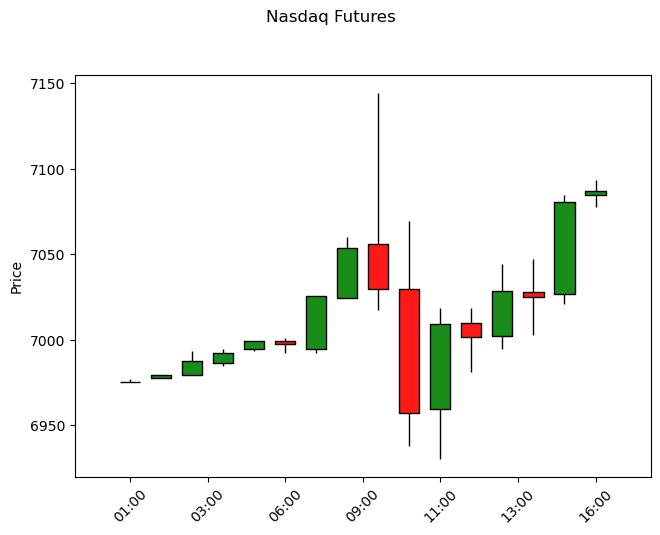

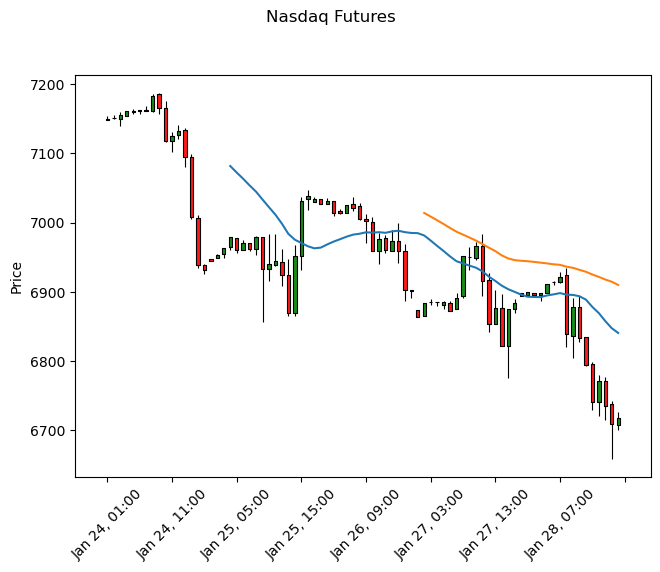

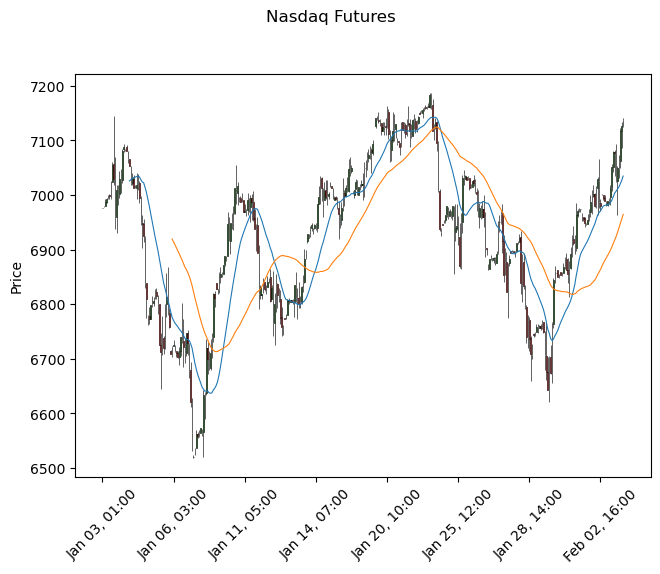

In [20]:
# Candles

def candles(df, start=None, end=None, mav=(20, 50), title='Nasdaq Futures'):
    d = df.copy()

    if start or end:
        d = d.loc[start:end]

    ohlc = d[['Open', 'High', 'Low', 'Close']].astype(float)
    mc = mpf.make_marketcolors(up='green', down='red', inherit=False)
    s  = mpf.make_mpf_style(marketcolors=mc)

    mpf.plot(ohlc, type='candle', title=title, style=s, mav=mav)

candles(df, start='2000-01-03 01:00', end='2000-01-03 16:00')   # day (8 Jan)
candles(df, start='2000-01-24 01:00', end='2000-01-28 16:00')   # two weeks (24 - 28 Jan)
candles(df, start='2000-01-03', end='2000-02-03')               # month (Jan 00 - Feb 00)

df.drop(columns=['High', 'Low'], inplace=True)

**In more complex strategies, we'd need more data, like the Volume and the Open Interest.**

In [21]:
# Other useful data

nq = yf.Ticker("NQ=F")
volume_data = nq.history(start="2000-01-03", end="2025-10-06")
volume_data.shape

(6325, 7)

**YFinance does not provide the complete data we need. We will therefore only focus on the features already included in the dataset.** 

## 4. Strategy 

**After all the checks, we are ready to implement the strategy**

**Since the time window of this dataset is extremely large (25 years), we will run the strategy only on a small portion of it. The range can be selected below, through 'df_strat'; in this example, I have chosen the last seven months of 2024.**
**The strategy is based on the most classical concept of statistical arbitrage: mean reversion. From the solution of the Ornstein–Uhlenbeck process, we know that the z-score tends to revert over time toward its mean: $z_t \sim \mathcal{N}\!\left(\mu, \, \frac{\sigma^2}{2\kappa}\right)$, and we will exploit this phenomenon to test the strategy.**

**The core of the strategy is the use of a Hidden Markov Model (HMM) to separate two regimes:**
- 0: "safe" state (mean-reverting)
- 1: volatile/risky state → the market is too volatile, OR the rolling-standardized value is not reliable. 

**The model is trained over a 750-day window (around 0.21 train-split), during which it learns to distinguish the parameters of the two states through the Baum–Welch (EM) algorithm.**

**The backtesting phase will serve solely as a validation of the strategy — our goal is certainly not to generate profit with such a simple model. To make the process more realistic, we will attempt to avoid the so-called “seven sins of backtesting”:**

- Survivorship bias
- Look-ahead bias
- Storytelling bias
- Overfitting and data snooping bias
- Turnover and transaction cost
- Outliers
- Asymmetric pattern and shorting cost.

**To avoid this kind of mistake, which is quite common in many projects, we will take several precautions. For example, trades will be generated one hour after the data is collected (.shift(1), that's why some green/red arrows in the BT graph below appear inverted), the model will not be given access to the entire time window, etc.**

**It should be noted that the model’s training window, the chosen time horizon, and the selected thresholds have a VERY STRONG influence on the final outcome. For this reason, the results should not be interpreted as a reliable way to evaluate the strategy itself.**

In [22]:
df_strat = df.loc['2024-06-01':'2025-01-01'].copy()
df_strat

,Open,Close,return,log_return,rolling_vol,rolling_mean,z-score
datetime,,,,,,,
2024-06-02 18:00:00,20035.00,20012.25,-0.000162,-0.000162,0.002168,-0.000154,-0.003775
2024-06-02 19:00:00,20011.75,20036.75,0.001224,0.001224,0.002167,-0.000163,0.640021
2024-06-02 20:00:00,20036.50,20077.50,0.002034,0.002032,0.002166,-0.000164,1.013877
2024-06-02 21:00:00,20077.75,20072.75,-0.000237,-0.000237,0.002172,-0.000158,-0.036398
2024-06-02 22:00:00,20073.00,20089.50,0.000834,0.000834,0.002170,-0.000166,0.460866
...,...,...,...,...,...,...,...
2025-01-01 19:00:00,21928.25,21892.50,-0.001699,-0.001700,0.002140,-0.000324,-0.642949
2025-01-01 20:00:00,21893.75,21956.75,0.002935,0.002930,0.002145,-0.000342,1.526053
2025-01-01 21:00:00,21956.00,21984.00,0.001241,0.001240,0.002142,-0.000344,0.739815


## 5. Hidden Markov Model

In [ ]:
# Train the model

window = 750
zs = df_strat['z-score'].values.reshape(-1, 1)  
n = len(zs)


model = GaussianHMM(
    n_components=2,
    covariance_type='diag',
    n_iter=200,
    tol=1e-4,    
    init_params="stmc",
    random_state=42
)
model.fit(zs[:window])

state_vars = model.covars_.reshape(model.n_components, -1).sum(axis=1)
hi_var_state = int(np.argmax(state_vars))
def remap(state_arr):
    # 1 = high variance, 0 = low variance
    return np.where(state_arr == hi_var_state, 1, 0)

regimes = np.empty(n - window, dtype=int)

for i in range(n - window):
    seq = zs[i : i + window + 1]          # NO look-ahead
    states = model.predict(seq)           # Viterbi algo
    regimes[i] = remap(states)[-1]        # last state = today's state

df_strat = df_strat.iloc[window:].copy()
df_strat['regime'] = regimes

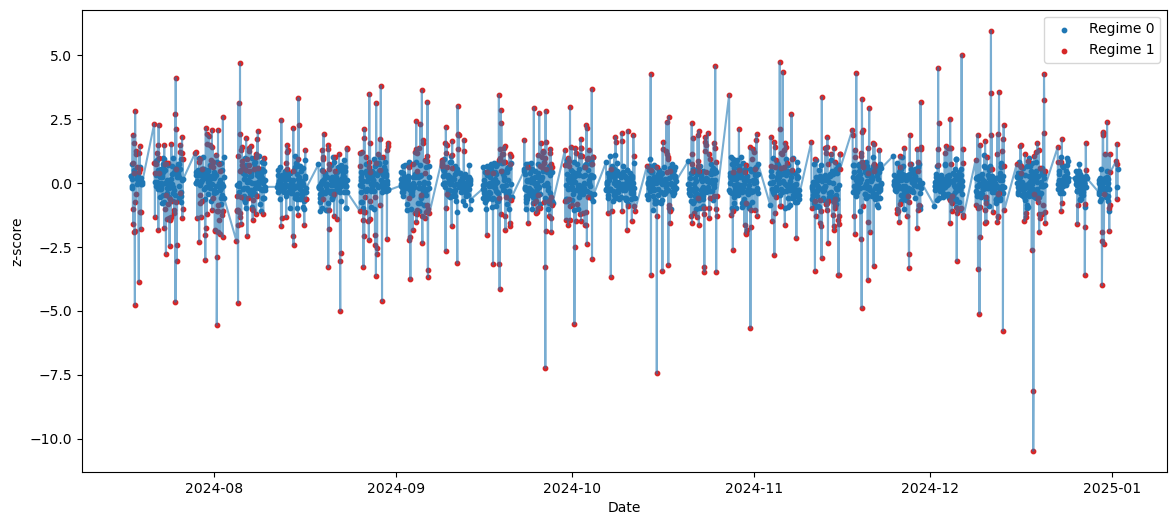

In [24]:
# HMM states

colors = {0: '#1f77b4', 1: '#d62728'}
plt.figure(figsize=(14, 6))
plt.plot(df_strat.index, df_strat['z-score'], alpha=0.6)
for state in [0, 1]:
    mask = df_strat['regime'] == state
    plt.scatter(
        df_strat.index[mask],
        df_strat['z-score'][mask],
        s=10,
        color = colors[state],
        label=f'Regime {state}'
    )
plt.xlabel('Date')
plt.ylabel('z-score')
plt.legend()
plt.show()

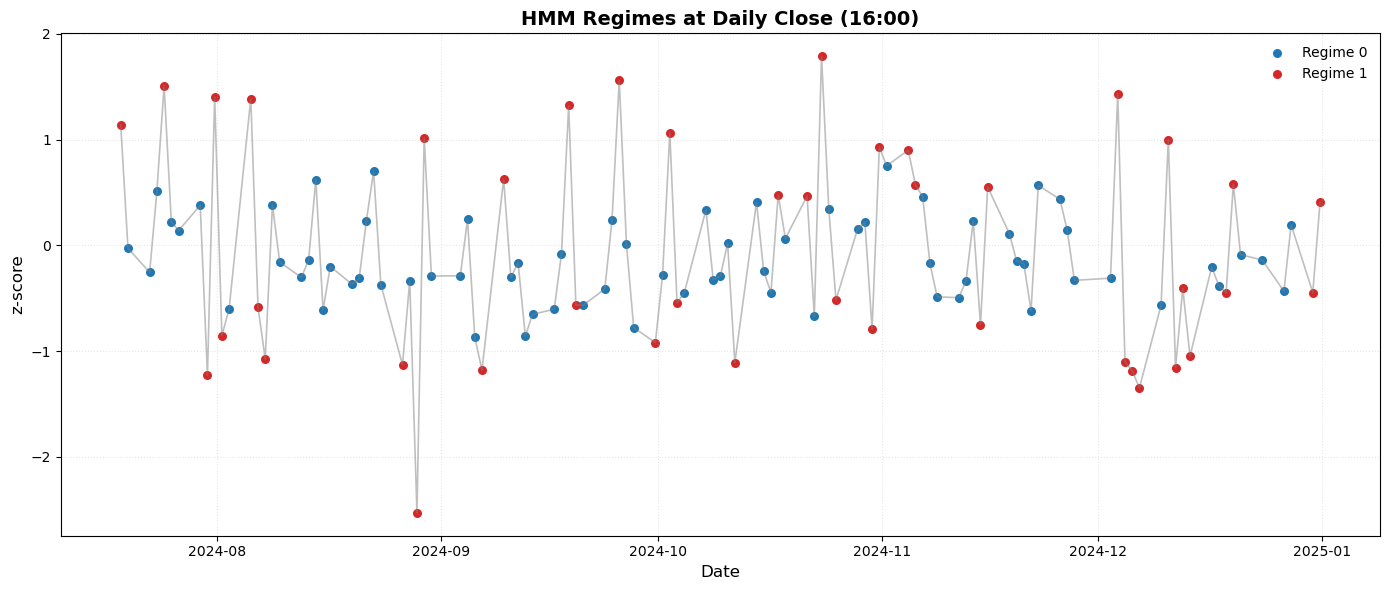

In [25]:
# HMM states (close prices) 

mask_close = df_strat.index.time == pd.Timestamp("16:00").time()
df_close = df_strat[mask_close].copy()

plt.figure(figsize=(14, 6))
plt.plot(df_close.index, df_close['z-score'], color='gray', alpha=0.5, linewidth=1.2)

for state, color in zip([0, 1], ['#1f77b4', '#d62728']):  # blu = low-var, red = high-var
    mask = df_close['regime'] == state
    plt.scatter(
        df_close.index[mask],
        df_close['z-score'][mask],
        s=30, color=color,
        label=f"Regime {state}"
    )
plt.title("HMM Regimes at Daily Close (16:00)", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("z-score", fontsize=12)
plt.legend(frameon=False)
plt.grid(alpha=0.3, linestyle=":")
plt.tight_layout()
plt.show()


=== HMM Gaussian emissions (mapped to regime 0/1) ===
Regime 0 (Low-variance): mu = -0.0124, sigma = 0.4130
Regime 1 (High-variance): mu = -0.0544, sigma = 1.7937
Empirical regime 0: variance = 0.1946, std = 0.4411
Empirical regime 1: variance = 3.5178, std = 1.8756


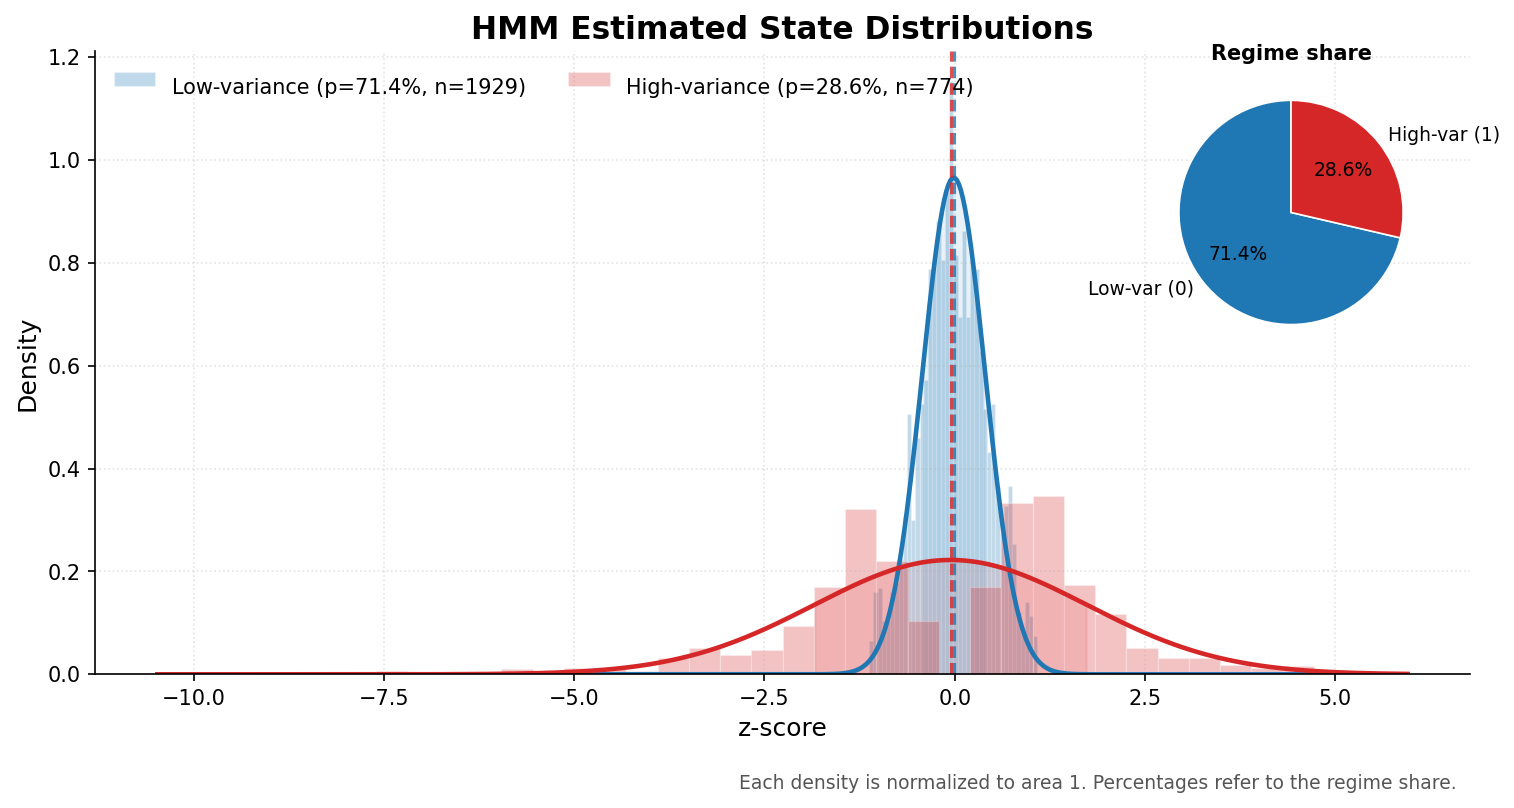

In [26]:
def plotHMM(df, model, feature_name='z-score'):

    means_raw = np.asarray(model.means_).squeeze()         
    cov = np.asarray(model.covars_)
    cov = np.squeeze(cov)                                  
    if cov.ndim == 1:
        stds_raw = np.sqrt(cov)                          
    elif cov.ndim == 2:
        stds_raw = np.sqrt(cov[:, 0])
    else:
        stds_raw = np.sqrt(cov[:, 0, 0])


    low_var_state_model  = int(np.argmin(stds_raw))
    high_var_state_model = int(np.argmax(stds_raw))

    mu_map  = {0: float(means_raw[low_var_state_model]),  1: float(means_raw[high_var_state_model])}
    std_map = {0: float(stds_raw[low_var_state_model]),   1: float(stds_raw[high_var_state_model])}

    print("=== HMM Gaussian emissions (mapped to regime 0/1) ===")
    for s in (0, 1):
        lab = "Low-variance" if s == 0 else "High-variance"
        print(f"Regime {s} ({lab}): mu = {mu_map[s]:.4f}, sigma = {std_map[s]:.4f}")

    if 'regime' not in df.columns:
        raise ValueError("df deve contenere la colonna 'regime' (0=low-var, 1=high-var).")
    if feature_name not in df.columns:
        raise ValueError(f"df deve contenere la colonna '{feature_name}'.")

    variances = df.groupby('regime')[feature_name].var()
    stds_emp  = df.groupby('regime')[feature_name].std()
    for state in variances.index:
        print(f"Empirical regime {state}: variance = {variances[state]:.4f}, std = {stds_emp[state]:.4f}")

    counts = df['regime'].value_counts().sort_index()
    pcts   = (counts / counts.sum() * 100).round(1)

    # plot
    plt.rcParams.update({
        "figure.dpi": 150, "axes.spines.top": False, "axes.spines.right": False,
        "axes.titleweight": "bold", "axes.grid": True, "grid.alpha": 0.35, "grid.linestyle": ":",
    })
    fig, ax = plt.subplots(figsize=(10, 5.5))
    colors = {0: "#1f77b4", 1: "#d62728"}

    x = np.linspace(df[feature_name].min(), df[feature_name].max(), 600)

    for s in (0, 1):
        data = df.loc[df['regime'] == s, feature_name].to_numpy()
        label = f'{"Low" if s==0 else "High"}-variance (p={pcts.get(s,0):.1f}%, n={int(counts.get(s,0))})'
        ax.hist(data, bins=40, density=True, alpha=0.28, label=label,
                color=colors[s], edgecolor="white", linewidth=0.6)

        m, sg = mu_map[s], std_map[s]
        pdf = (1.0 / (sg * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - m) / sg) ** 2)
        ax.plot(x, pdf, color=colors[s], linewidth=2.2)
        ax.axvline(m, color=colors[s], linestyle="--", linewidth=1.5, alpha=0.8)
        ax.fill_between(x, 0, pdf, where=(x >= m - sg) & (x <= m + sg),
                        color=colors[s], alpha=0.10)

    ax.set_title("HMM Estimated State Distributions", fontsize=15)
    ax.set_xlabel(feature_name, fontsize=12)
    ax.set_ylabel("Density", fontsize=12)
    ax.text(0.99, -0.16,
            "Each density is normalized to area 1. Percentages refer to the regime share.",
            transform=ax.transAxes, ha="right", va="top", fontsize=9, color="#555")

    leg = ax.legend(frameon=False, fontsize=10, ncol=2, loc="upper left")
    for t in leg.get_texts():
        t.set_va("center_baseline")

    axins = inset_axes(ax, width="23%", height="45%", loc="upper right", borderpad=1.0)
    axins.set_title("Regime share", fontsize=10, pad=6)
    axins.pie([counts.get(0, 0), counts.get(1, 0)],
              labels=["Low-var (0)", "High-var (1)"],
              autopct="%1.1f%%", startangle=90,
              colors=[colors[0], colors[1]],
              wedgeprops={"edgecolor": "white", "linewidth": 0.8},
              textprops={"fontsize": 9})

    plt.tight_layout(); plt.show()


plotHMM(df_strat, model)

In [27]:
# Transition matrix

A = model.transmat_
print(A)

[[0.88299756 0.11700244]
 [0.25109357 0.74890643]]


**From the transition matrix, we can see that once we enter one of the two states, we tend to remain there.**

### TRADING SIGNALS

**Here we define the rules for generating trading signals (short/long/hold). The signals will be executed the next hour in order to avoid look-ahead bias and obtain more realistic results.**

In [ ]:
def generate_signals(df_strat, entry_thresh, exit_thresh):
    sig = np.zeros(len(df_strat), dtype=int)
    position = 0

    for i in range(len(df_strat)):
        z = df_strat.loc[df_strat.index[i], 'z-score']
        regime = df_strat.loc[df_strat.index[i], 'regime'] 

        if pd.isna(z) or pd.isna(regime):
            sig[i] = position
            continue

        if regime == 1: 
            position = 0
        else:
            if position == 0:
                if z >= entry_thresh:
                    position = -1   # short
                elif z <= -entry_thresh:
                    position = 1    # long
            else:
                if abs(z) < exit_thresh:
                    position = 0    # close

        sig[i] = position

    return sig

df_strat['signal'] = generate_signals(df_strat, entry_thresh=0.45, exit_thresh=0.1) # --> EXAMPLE (best params from grid-search)
df_strat['position'] = df_strat['signal'].shift(1).fillna(0)  # execution at t+1

# 'position' will be the same as the previous 'signal'

## 6. Backtest

In [ ]:
initial_capital = 10000.0

# returns and costs
df_strat['ret'] = df_strat['Close'].pct_change().fillna(0.0)
pos = df_strat['position'].fillna(0.0).astype(float)
ret_gross = pos * df_strat['ret']

units_change = pos.diff().abs().fillna(pos.abs())

tick_size = 0.25
tick_value = 5.0
point_value = 20.0
commission_per_side = 2.0
slippage_ticks_per_side = 0.5
per_side_cost_usd = commission_per_side + slippage_ticks_per_side * tick_value
exec_price = df_strat['Open'].clip(lower=1e-9)  
trade_cost_ret = (per_side_cost_usd * units_change) / (exec_price * point_value)
trade_cost_ret = trade_cost_ret.replace([np.inf, -np.inf], 0.0).fillna(0.0)

df_strat['strategy_ret'] = (ret_gross - trade_cost_ret).astype(float).fillna(0.0)
df_strat['benchmark_ret'] = df_strat['ret']
df_strat['strategy_cum']  = (1.0 + df_strat['strategy_ret']).cumprod() * initial_capital
df_strat['benchmark_cum'] = (1.0 + df_strat['benchmark_ret']).cumprod() * initial_capital


# metrics
def metrics(
    df: pd.DataFrame,
    ret_col: str = "strategy_ret",
    initial_capital: float = 100.0,
    rf_per_period: float = 0.0,  
    sortino_target: float = 0.0,
    periods_per_year: int | None = None
):
    r = pd.Series(df[ret_col]).dropna().astype(float)
    if len(r) == 0:
        return {k: np.nan for k in ["CAGR","Ann. Volatility","Sharpe","Sortino","Max Drawdown","Calmar"]}

    if periods_per_year is None:
        periods_per_year = 16 * 252  # 16 RTH * 252 days

    equity = (1 + r).cumprod() * float(initial_capital)
    n_years = len(r) / periods_per_year if periods_per_year > 0 else np.nan

    cagr = (equity.iloc[-1] / float(initial_capital)) ** (1 / n_years) - 1 if n_years and n_years > 0 else np.nan
    ann_vol = r.std(ddof=1) * np.sqrt(periods_per_year)

    rex = r - rf_per_period
    denom = rex.std(ddof=1) * np.sqrt(periods_per_year)
    sharpe = (rex.mean() * periods_per_year) / denom if denom and denom > 0 else np.nan

    downside = r[r < sortino_target] - sortino_target
    downside_dev = downside.std(ddof=1) * np.sqrt(periods_per_year) if len(downside) > 1 else np.nan
    sortino = ((r.mean() - sortino_target) * periods_per_year) / downside_dev if (isinstance(downside_dev, float) and downside_dev > 0) else np.nan

    roll_max = equity.cummax()
    drawdown = equity / roll_max - 1.0
    max_dd = float(drawdown.min())
    calmar = cagr / abs(max_dd) if (isinstance(cagr, float) and max_dd < 0) else np.nan

    return {"CAGR": cagr, "Ann. Volatility": ann_vol, "Sharpe": sharpe,
            "Sortino": sortino, "Max Drawdown": max_dd, "Calmar": calmar}




PERIODS_PER_YEAR = 16 * 252
ANNUAL_RF = 0.003
RF_PER_PERIOD = ANNUAL_RF / PERIODS_PER_YEAR

m = metrics(
    df_strat,
    ret_col="strategy_ret",
    initial_capital=initial_capital,
    rf_per_period=RF_PER_PERIOD,
    periods_per_year=PERIODS_PER_YEAR
)
for k, v in m.items():
    if k in {"CAGR","Ann. Volatility","Max Drawdown"} and pd.notna(v):
        print(f"{k}: {v:.2%}")
    elif k in {"Sharpe","Sortino","Calmar"} and pd.notna(v):
        print(f"{k}: {v:.2f}")
    else:
        print(f"{k}: {v}")


CAGR: 20.45%
Ann. Volatility: 7.54%
Sharpe: 2.47
Sortino: 2.55
Max Drawdown: -3.87%
Calmar: 5.28


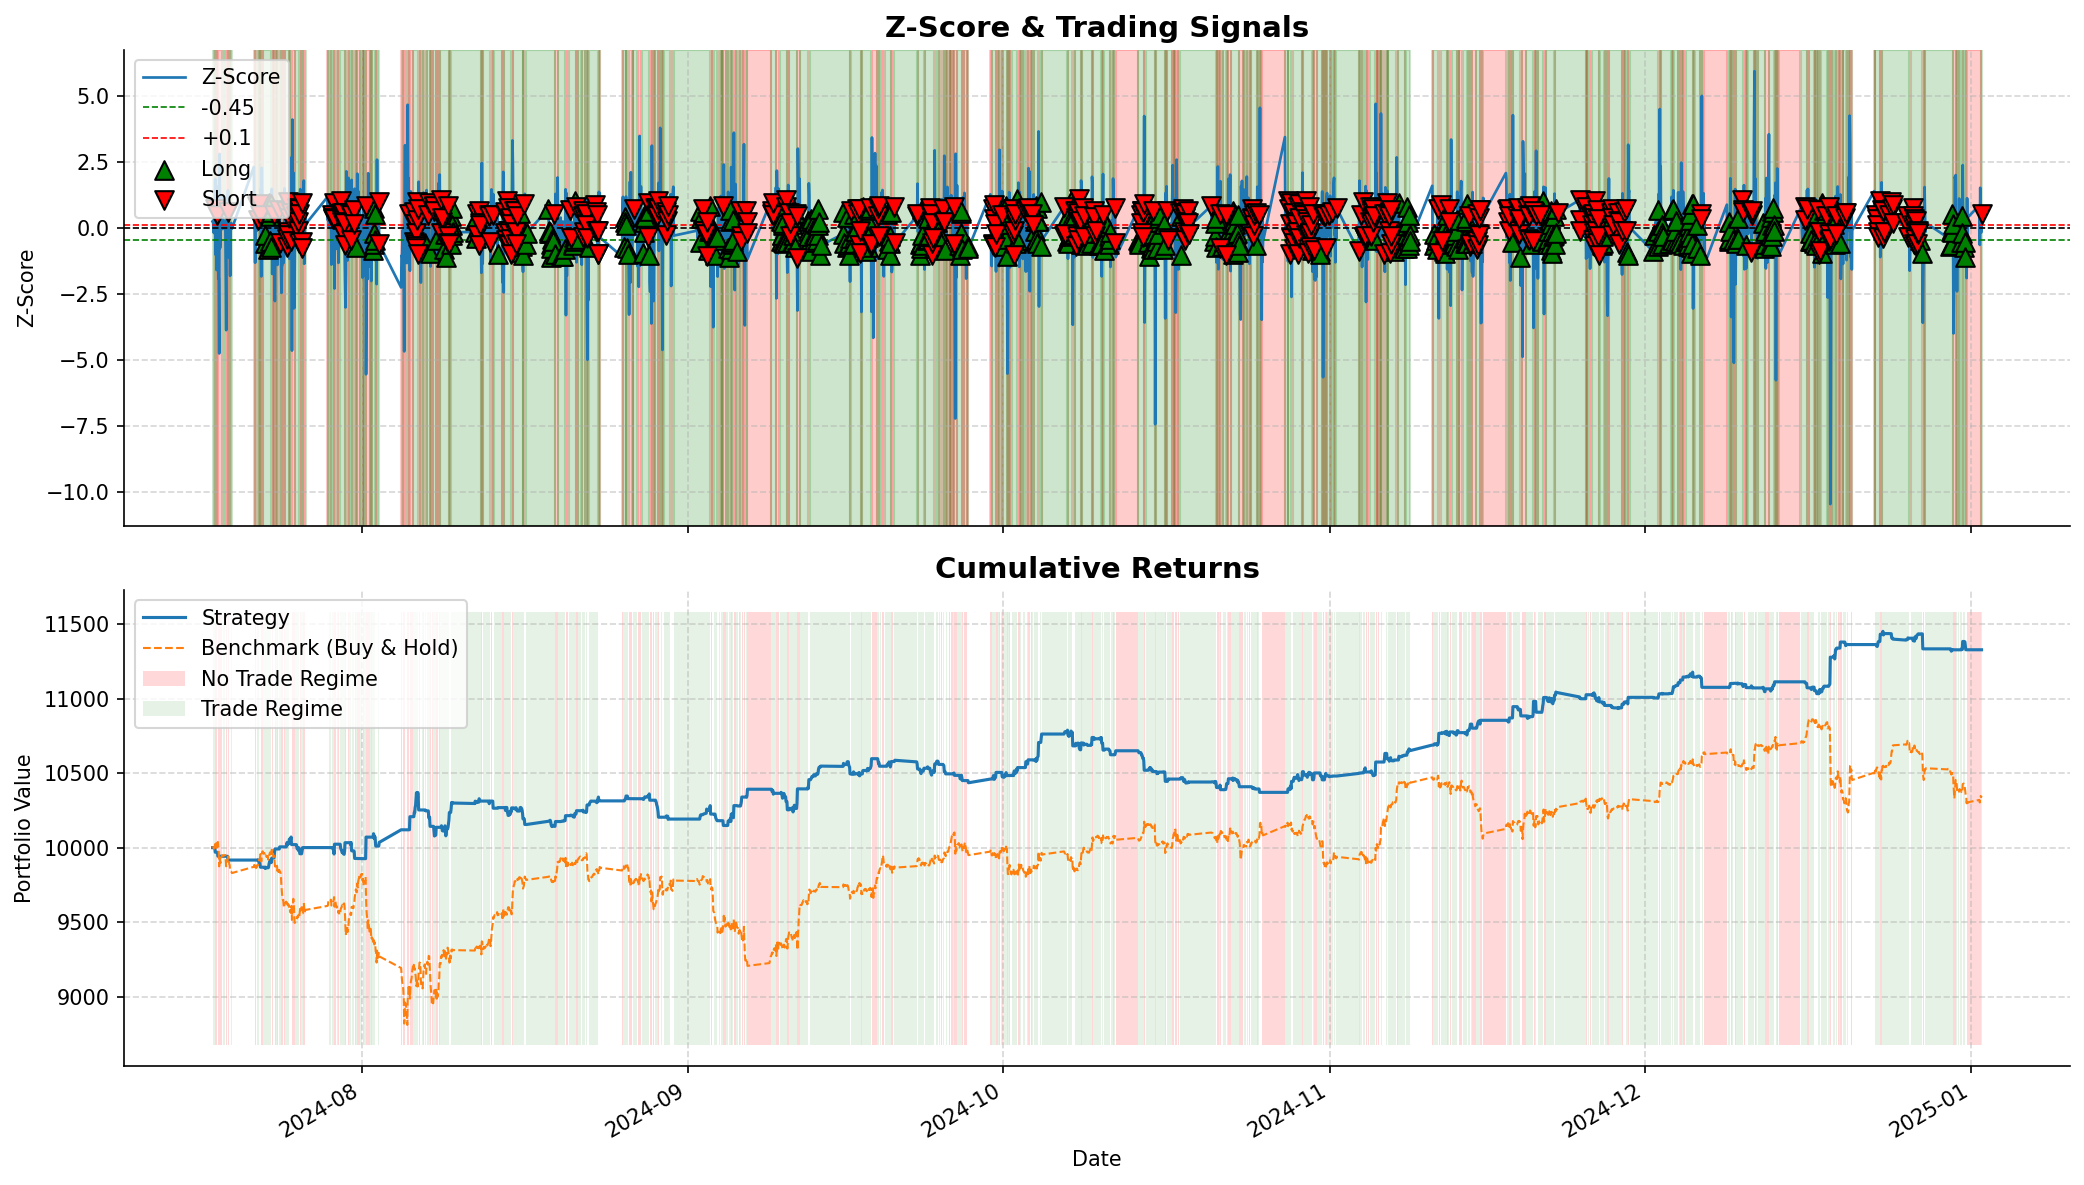

In [30]:
# BT PLOTS

entry_thresh = 0.45 
exit_thresh = 0.1

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14, 8), sharex=True)

x = df_strat.index
in_regime = df_strat['regime'] == 1  # red: risky
out_regime = df_strat['regime'] == 0 # green: mean-reverting (safe)

# Subplot 1
ax1.fill_between(x, 0, 1, where=in_regime,  color='red',   alpha=0.2, transform=ax1.get_xaxis_transform())
ax1.fill_between(x, 0, 1, where=out_regime, color='green', alpha=0.2, transform=ax1.get_xaxis_transform())

ax1.plot(x, df_strat['z-score'], linewidth=1.3, label='Z-Score')
ax1.axhline(-entry_thresh, linestyle='--', linewidth=0.8, color='green', label=f'-{entry_thresh}')
ax1.axhline( exit_thresh, linestyle='--', linewidth=0.8, color='red',   label=f'+{exit_thresh}')
ax1.axhline(0, color='black', linewidth=0.8, linestyle='--')

long_idx  = df_strat.index[df_strat['signal'] ==  1]
short_idx = df_strat.index[df_strat['signal'] == -1]

ax1.scatter(long_idx,  df_strat.loc[long_idx, 'z-score'], marker='^', s=80,
            edgecolor='k', facecolor='green', label='Long',  zorder=5)
ax1.scatter(short_idx, df_strat.loc[short_idx, 'z-score'], marker='v', s=80,
            edgecolor='k', facecolor='red',   label='Short', zorder=5)

ax1.set_title('Z-Score & Trading Signals', fontsize=14)
ax1.set_ylabel('Z-Score')
ax1.legend(loc='upper left')
ax1.grid(True, linestyle='--', alpha=0.5)


# Subplot 2
ax2.plot(x, df_strat['strategy_cum'],  label="Strategy", linewidth=1.5)
ax2.plot(x, df_strat['benchmark_cum'], label="Benchmark (Buy & Hold)", linestyle='--', linewidth=1.0)

ymin2, ymax2 = ax2.get_ylim()
ax2.fill_between(x, ymin2, ymax2, where=in_regime,  facecolor='red',  alpha=0.15, label="No Trade Regime")
ax2.fill_between(x, ymin2, ymax2, where=out_regime, facecolor='green', alpha=0.1, label="Trade Regime")

ax2.set_title('Cumulative Returns', fontsize=14)
ax2.set_ylabel('Portfolio Value')
ax2.set_xlabel('Date')
ax2.legend(loc='upper left')
ax2.grid(True, linestyle='--', alpha=0.5)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()


**Here is a zoomed version of the first plot to better visualize the trades.**

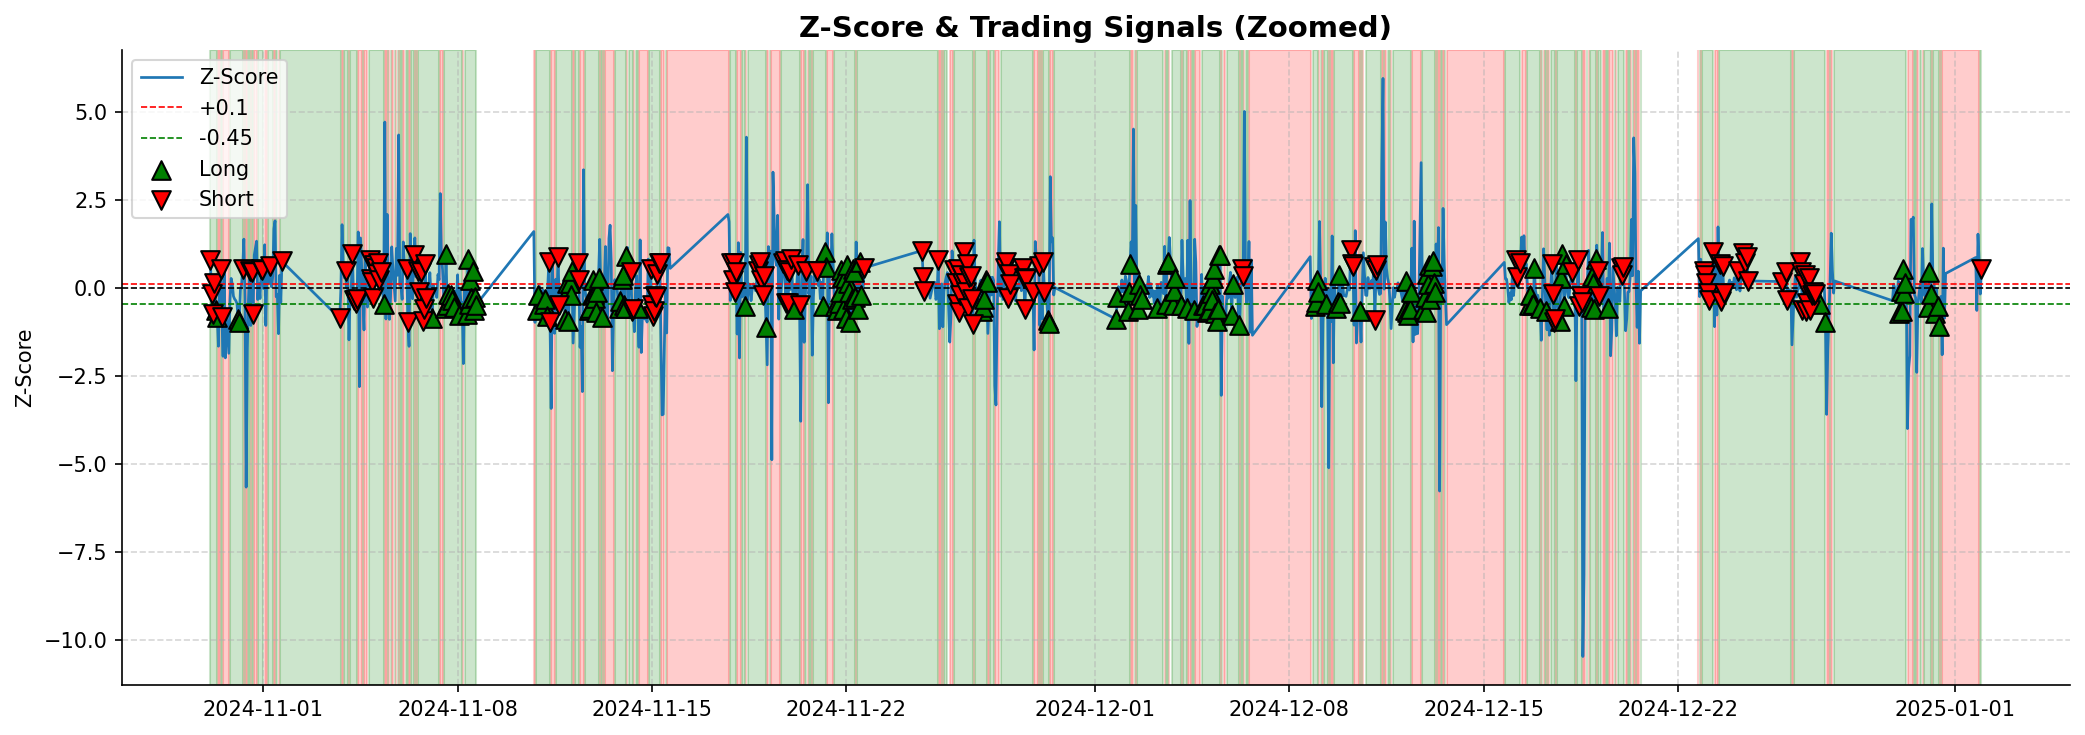

In [31]:
# ZOOMED SIGNAL PLOT (LAST 1000)

df_zoom = df_strat.iloc[-1000:].copy()

entry_thresh = 0.45 
exit_thresh  = 0.1

fig, ax = plt.subplots(figsize=(14, 5))

x = df_zoom.index
in_regime  = df_zoom['regime'] == 1
out_regime = df_zoom['regime'] == 0

ax.fill_between(x, 0, 1, where=in_regime,  color='red',   alpha=0.2, transform=ax.get_xaxis_transform())
ax.fill_between(x, 0, 1, where=out_regime, color='green', alpha=0.2, transform=ax.get_xaxis_transform())

ax.plot(x, df_zoom['z-score'], linewidth=1.3, label='Z-Score')
ax.axhline(exit_thresh,  linestyle='--', linewidth=0.8, color='red',   label=f'+{exit_thresh}')
ax.axhline(-entry_thresh, linestyle='--', linewidth=0.8, color='green', label=f'-{entry_thresh}')
ax.axhline(0, color='black', linewidth=0.8, linestyle='--')

long_idx  = df_zoom.index[df_zoom['signal'] ==  1]
short_idx = df_zoom.index[df_zoom['signal'] == -1]

ax.scatter(long_idx,  df_zoom.loc[long_idx, 'z-score'], marker='^', s=80,
           edgecolor='k', facecolor='green', label='Long',  zorder=5)
ax.scatter(short_idx, df_zoom.loc[short_idx, 'z-score'], marker='v', s=80,
           edgecolor='k', facecolor='red',   label='Short', zorder=5)

ax.set_title('Z-Score & Trading Signals (Zoomed)', fontsize=14)
ax.set_ylabel('Z-Score')
ax.legend(loc='upper left')
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


**Note that this is just an example.**

**The following code performs a grid search over entry and exit thresholds, backtesting the strategy across multiple threshold combinations to identify the most effective pair.**

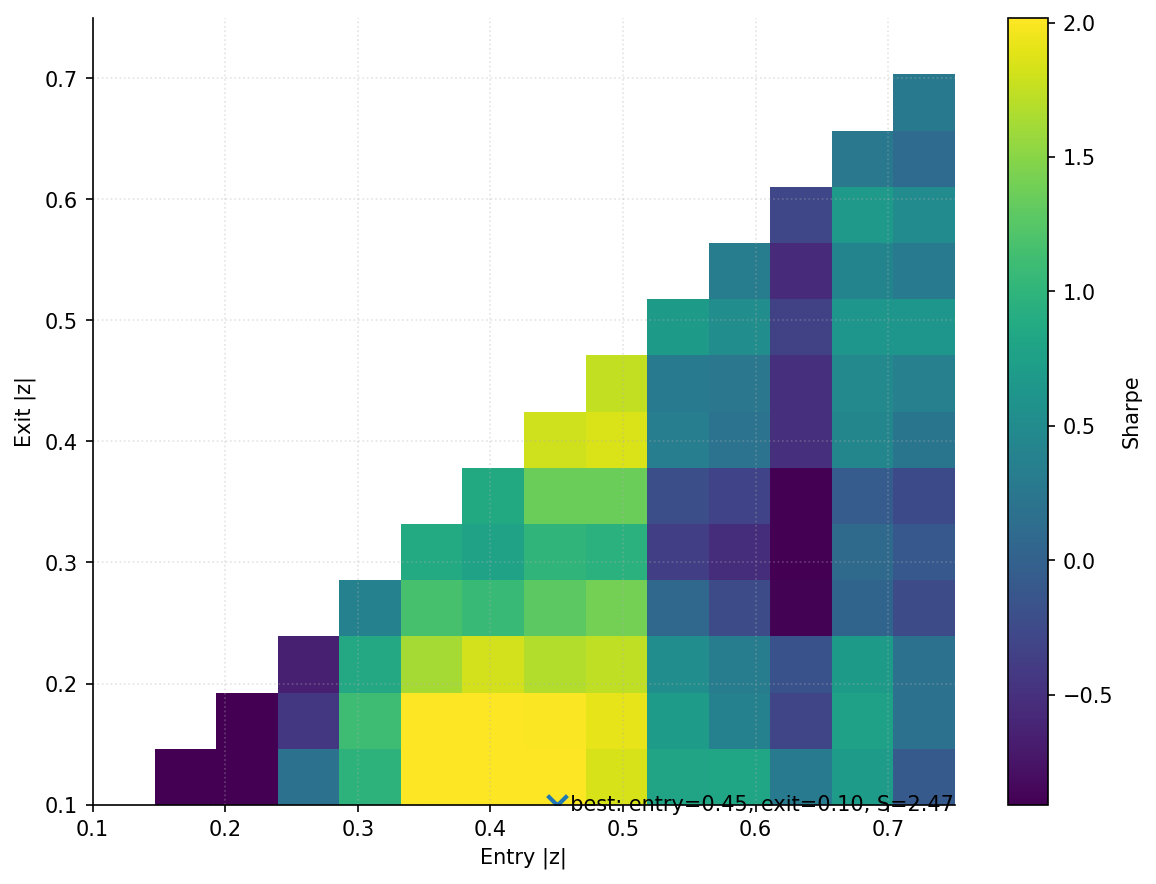

Best Combination: entry=0.45, exit=0.10 → Sharpe=2.47
Median Sharpe: 0.38
Average Sharpe: 0.51


In [ ]:
def sharpe_for_thresholds_single(df, entry_thresh, exit_thresh, periods_per_year, rf_per_period):
    if exit_thresh >= entry_thresh:
        return np.nan

    d = df.copy()
    d['signal'] = generate_signals(d, entry_thresh=entry_thresh, exit_thresh=exit_thresh)
    d['position'] = d['signal'].shift(1).fillna(0.0).astype(float)

    ret = d['Close'].pct_change().fillna(0.0).astype(float)
    pos = d['position']
    ret_gross = (pos * ret).replace([np.inf, -np.inf], 0.0).fillna(0.0)

    commission_per_side = 2.0
    slippage_ticks_per_side = 0.5
    tick_value = 5.0
    point_value = 20.0

    units_change = pos.diff().abs().fillna(pos.abs())
    per_side_cost_usd = commission_per_side + slippage_ticks_per_side * tick_value
    exec_price = d['Open'].astype(float).clip(lower=1e-9)
    cost = (per_side_cost_usd * units_change) / (exec_price * point_value)
    cost = cost.replace([np.inf, -np.inf], 0.0).fillna(0.0)

    strat_ret = (ret_gross - cost).replace([np.inf, -np.inf], 0.0).fillna(0.0)
    if (pos.abs().sum() == 0) or (strat_ret.std(ddof=1) == 0):
        return 0.0

    rex = strat_ret - rf_per_period
    denom = rex.std(ddof=1) * (periods_per_year ** 0.5)
    if denom <= 0 or not np.isfinite(denom):
        return 0.0
    sharpe = (rex.mean() * periods_per_year) / denom
    return float(sharpe) if np.isfinite(sharpe) else 0.0


def gridsearch_thresh(df_for_grid, entry_range, exit_range, periods_per_year, rf_per_period):
    d = df_for_grid.copy()
    d = d.replace([np.inf, -np.inf], np.nan).dropna(subset=['Open','Close'])

    E = np.asarray(entry_range, dtype=float)
    X = np.asarray(exit_range, dtype=float)
    Z = np.full((len(X), len(E)), np.nan, dtype=float)

    for i, ex in enumerate(X):
        for j, en in enumerate(E):
            if ex >= en:
                continue
            Z[i, j] = sharpe_for_thresholds_single(
                d, en, ex,
                periods_per_year=periods_per_year,
                rf_per_period=rf_per_period
            )

    best_idx = np.nanargmax(Z)
    best_i, best_j = np.unravel_index(best_idx, Z.shape)
    best_exit, best_entry = X[best_i], E[best_j]
    best_sharpe = Z[best_i, best_j]

    Zmask = np.ma.masked_invalid(Z)
    Zplot = Zmask.data.copy()

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(
        Zplot, origin='lower', aspect='auto',
        extent=[E.min(), E.max(), X.min(), X.max()],
        interpolation='nearest', cmap='viridis',
        norm=Normalize(
            vmin=np.nanpercentile(Z, 5),
            vmax=np.nanpercentile(Z, 95)
        )
    )
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Sharpe')

    ax.set_xlabel('Entry |z|')
    ax.set_ylabel('Exit |z|')
    ax.scatter([best_entry], [best_exit], marker='x', s=90, linewidths=2)
    ax.text(best_entry, best_exit,
            f'  best: entry={best_entry:.2f}, exit={best_exit:.2f}, S={best_sharpe:.2f}',
            va='center', ha='left')

    plt.tight_layout()
    plt.show()

    print(f"Best Combination: entry={best_entry:.2f}, exit={best_exit:.2f} → Sharpe={best_sharpe:.2f}")
    print(f"Median Sharpe: {np.nanmedian(Z):.2f}")
    print(f"Average Sharpe: {np.nanmean(Z):.2f}")

    return pd.DataFrame(Z, index=X, columns=E)


df_win = df_strat.copy()

PERIODS_PER_YEAR = 16 * 252
ANNUAL_RF = 0.003
RF_PER_PERIOD = ANNUAL_RF / PERIODS_PER_YEAR
entry_vals = np.round(np.arange(0.10, 0.8, 0.05), 2)
exit_vals  = np.round(np.arange(0.10, 0.8, 0.05), 2)

grid_df = gridsearch_thresh(
    df_win,
    entry_range=entry_vals,
    exit_range=exit_vals,
    periods_per_year=PERIODS_PER_YEAR,
    rf_per_period=RF_PER_PERIOD
)


**We can clearly see a "yellow area" where the Sharpe is around 1. The strategy appears to deliver acceptable results in some cases: if we use the range 0.1-0.5 to perform the grid-search, we obtain a median Sharpe of 1.32 and an Average Sharpe of 1.12. Even if the best result obtained with the grid search seems very good (Sharpe = 2.47, Sortino = 2.55, too high to be realistic), it does not mean that the strategy is a gold mine, since the entry/exit thresh were chosen ex-post (after executing the strategy several times with different params). Because of this choice, these results are subject to overfitting and should not be interpreted as indicative of future performance.** 

**Therefore it is important to note that the backtesting phase is NOT considered an essential component of this project, as results are strongly dependent on parameter choices (entry/exit thresholds, rolling mean and std, training window length, HMM configuration, dates window, etc.)** 

**For these reasons, backtesting is used here primarily as an exploratory and validation tool to verify the correct functioning of the the strategy, rather than as a definitive measure of robustness or profitability.** 

FUTURE WORK:
- dynamic entry and exit thresholds
- re-fit the HMM periodically
- deeper optimization of model parameters 
- inclusion of additional risk management layers
